<a href="https://colab.research.google.com/github/balgard/Card-King/blob/master/Algard_Project_2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brendan Algard Project 2
Your project should address the categories below. 
##Points:9/18
Explore data +5 \
Data Prep +1 \
Metrics +1 \
Model Planning +1 \
SVC +1 \

## Problem:



Metrics [1]: I'll use the classification report function from sci-kit learn, this includes the precision, recall, f1-score, and support metrics.  I'll also use accuracy because it's a simple metric even if it's not that great.  I'm using the others because they are the most commonly used metrics for classification and I think the classification report is a neat tool I haven't used yet. \

Model Planning and Execution [1]:
- SVC: This took too long to run, no parameters tuned as a result
- PCA: Number of components
- Perceptron: Max iterations and alpha
- MLP: Layers

Bumps in the Road [1 point]: What challenges did you encounter? How did you overcome these challenges? Did you have to adapt your strategy to account for these challenges? Why or why not? \
Results [1 point]: After you conduct your learning experiment, summarize the results you got. Include visualizations as appropriate. \
Conclusions: What insights/recommendations do you have? What did you find that was interesting? Which model was your best model, which models didn't work well? Why do you think this is? In general, I want a discussion of your experiment, the results, and what they mean.

In [1]:
import pandas as pd
from google.colab import drive
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
import warnings
from sklearn.decomposition import PCA

In [11]:
nltk.download() #in Corpora tab, download stopwords

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

# Input Pipeline (sklearn):

In [3]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/CS_167_Files/CS_167_Data/IMDB_Dataset.csv')
data.head()

Mounted at /content/drive


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Exploration:
- Number of samples
- Number of classes of the target variable
- Number of words per sample
- Distribution of sample length
- Something else: get creative :) 
- I decided to look at the mean/median of the word counts of both positive and negative reviews
 - This proved unhelpful so I looked at the number of unique words in different sentiments
 - I hoped that either a negative or positive review would have a signifigantly different word count than the other
 - That wasn't the case

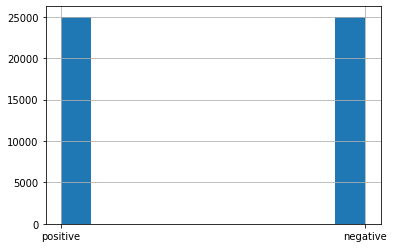

In [4]:
## Use cells here to explore the data:
data.sentiment.hist()


In [5]:
data.size

100000

In [6]:
print("Number of samples:", data.size)
print("Number of classes?:",np.unique(data.sentiment.values).size)
print("Classes:",np.unique(data.sentiment.values))

Number of samples: 100000
Number of classes?: 2
Classes: ['negative' 'positive']


Median # of words/sample:lengths    970.0
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc4e53e590>]],
      dtype=object)

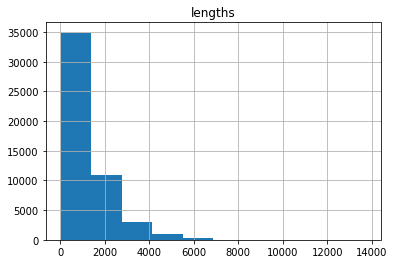

In [7]:
lengths = []
for idx,row in data.iterrows():
  lengths.append(len(row.review))
lengths = pd.DataFrame(lengths,columns=['lengths'])
print("Median # of words/sample:{}".format(lengths.median()))
lengths.hist()

### Extra Data Explore Step

In [8]:
print("Mean # of words/sample:{}".format(lengths.mean()))
pos_lengths = []
neg_lengths = []
pos_uniques = []
neg_uniques = []
for idx,row in data.iterrows():
  if data.sentiment.iloc[idx] == 'negative':
    neg_lengths.append(len(row.review))
    neg_uniques.append(len(set(row.review.split())))
  else:
    pos_lengths.append(len(row.review))
    pos_uniques.append(len(set(row.review.split())))
pos_lengths = pd.DataFrame(pos_lengths,columns=['lengths'])
neg_lengths = pd.DataFrame(neg_lengths,columns=['lengths'])
pos_uniques = pd.DataFrame(pos_uniques,columns=['lengths'])
neg_uniques = pd.DataFrame(neg_uniques,columns=['lengths'])
print("Median # of words/positive sample:{}".format(pos_lengths.median()))
print("Median # of words/negative sample:{}".format(neg_lengths.median()))
print("Mean # of words/positive sample:{}".format(pos_lengths.mean()))
print("Mean # of words/negative sample:{}".format(neg_lengths.mean()))
print()
print("Median # of unique words/positive sample:{}".format(pos_uniques.median()))
print("Median # of unique words/negative sample:{}".format(neg_uniques.median()))
print("Mean # of unique words/positive sample:{}".format(pos_uniques.mean()))
print("Mean # of unique words/negative sample:{}".format(neg_uniques.mean()))

Mean # of words/sample:lengths    1309.43102
dtype: float64
Median # of words/positive sample:lengths    968.0
dtype: float64
Median # of words/negative sample:lengths    973.0
dtype: float64
Mean # of words/positive sample:lengths    1324.79768
dtype: float64
Mean # of words/negative sample:lengths    1294.06436
dtype: float64

Median # of unique words/positive sample:lengths    122.0
dtype: float64
Median # of unique words/negative sample:lengths    124.0
dtype: float64
Mean # of unique words/positive sample:lengths    152.0156
dtype: float64
Mean # of unique words/negative sample:lengths    152.2662
dtype: float64


## Data Preparation

I'm providing you with code that cleans the reviews by making it all lowercase letters and removing stop words. The three cells below do this for you. I still want you to explain what you did with the data here. 



### Data Prep Explaination
The clean_review method uses regular expressions to remove anything that's not in the accepted dictionary from the passed in review, it then removes any stopwords from it given by the stopwords downloaded earlier. \

The following loop goes through every line in data and applies the clean_review function to it. \

Removing all of the extra non-useful information allows for vectorizing the actual useful data later on. \


In [12]:
#This is a function that takes in a review, makes sure it is only lower case letters and removes stopwords.
#It returns the cleaned review text.
def clean_review(review):
    #input is a string review
    #return is review cleaned of all punctuation, lowercase, and removed nltk stopwords
    letters_only = re.sub("[^a-zA-Z]"," ",review)
    lower_case = letters_only.lower()
    words = lower_case.split()
    for stop_word in stopwords.words("english"):
        while stop_word in words:
            words.remove(stop_word)
    cleaned = " ".join(words)
    return cleaned

In [13]:
#process the data
cleaned_text = []
for i in range(len(data)):
    cleaned_text.append(clean_review(data["review"][i]))  

In [ ]:
cleaned_text[:5]

In [15]:
#establish training and testing dataset
train_data, test_data, train_sln, test_sln = \
    train_test_split(cleaned_text, data['sentiment'], test_size = 0.2, random_state=0) 

### Vectorizing the data

**CountVectorizer**: Convert a collection of text documents to a matrix of token counts

In [16]:
#Bag of Words with 5000 most common words
vectorizer = CountVectorizer(analyzer='word', max_features = 500)
#find the right 5000 words
vectorizer.fit(train_data)

#use the vectorizer to transform review strings into word count vectors 
train_data_vectors = vectorizer.transform(train_data).toarray()
test_data_vectors = vectorizer.transform(test_data).toarray()

The SVC took about 30 minutes to run and I didn't want to work around fixing it so I just left it as is and didn't tune this one, I did tune the other models though.

In [17]:
## Now use train_data_vectors and test_data_vectors to train/test/tune your sklearn models.
clf = SVC()
clf.fit(train_data_vectors,train_sln)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
predictions = clf.predict(test_data_vectors)

In [22]:
print("accuracy:", metrics.accuracy_score(test_sln, predictions))
vals = data['sentiment'].unique() ## possible classification values
conf_mat = metrics.confusion_matrix(test_sln, predictions, labels=vals)
print(pd.DataFrame(conf_mat, index = "T " + vals, columns = "Pred " + vals))

accuracy: 0.8307
            Pred positive  Pred negative
T positive           4203            762
T negative            931           4104


In [31]:
print(metrics.classification_report(test_sln,predictions))

              precision    recall  f1-score   support

    negative       0.84      0.82      0.83      5035
    positive       0.82      0.85      0.83      4965

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

